## Fetch and Init Images

In [6]:
# First, install the autoreload extension
%load_ext autoreload
%autoreload 2

# Import necessary libraries
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Add your package to the system path
sys.path.append(str(Path('../src').resolve()))

from co_op_translator.config.constants import (
    SUPPORTED_IMAGE_EXTENSIONS)

# from co_op_translator.core.project import ProjectTranslator
from co_op_translator.core.vision import image_translator

# Create an instance of ImageTranslator
root_dir = Path('.').resolve()
image_translator_instance = image_translator.ImageTranslator.create(default_output_dir=f"{str(root_dir)}/translated", root_dir=str(root_dir))

# # Get all PNG and jpeg/jpg images in the current directory
# image_paths = list(Path('./images').glob('*.png'))
image_paths = []
for ext in SUPPORTED_IMAGE_EXTENSIONS:
    image_paths.extend(Path('./images').rglob(f'*{ext}'))

print(image_paths)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PosixPath('images/RAIPrinciples_tilt2.jpeg'), PosixPath('images/RAIPrinciples_tilt1.jpeg'), PosixPath('images/demo_tilt.jpeg'), PosixPath('images/AIStudio.png'), PosixPath('images/Phi3getstarted.png'), PosixPath('images/demo.png'), PosixPath('images/00-01-architecture.png'), PosixPath('images/RAIPrinciples.png')]


## Process and Save data from Azure Computer Vision and OpenAI

In [8]:
from co_op_translator.utils.common.file_utils import generate_translated_filename
from co_op_translator.config.font_config import FontConfig
from co_op_translator.core.llm.text_translator import TextTranslator


import logging
logger = logging.getLogger(__name__)
font_config = FontConfig()


# Setup Image and Text Translators
text_translator = TextTranslator.create()
image_translator_instance = image_translator.ImageTranslator.create(
    default_output_dir=f"{str(root_dir)}/translated", root_dir=str(root_dir)
)
target_language_code = "es"
target_language_name = font_config.get_language_name(target_language_code)

destination_path = "./translated_images"

data = {}

# Translate and visualize each image
for image_path in image_paths:
    # Check if the image is supported
    if image_path.suffix not in SUPPORTED_IMAGE_EXTENSIONS:
        print(f"{image_path.name} is not a supported image format")
        continue

    new_filename = generate_translated_filename(
        image_path, target_language_code, root_dir
    )
    line_bounding_boxes = image_translator_instance.extract_line_bounding_boxes(
        image_path
    )
    text_data = [line["text"] for line in line_bounding_boxes]

    translated_text_list = text_translator.translate_image_text(
        text_data, target_language_name
    )
    data[image_path] = [line_bounding_boxes, translated_text_list]



### Save data

In [12]:
import json
# Convert PosixPath keys to strings
data_str_keys = {str(key): value for key, value in data.items()}

# Save data as a JSON file
with open("translated_data.json", "w") as f:
    json.dump(data_str_keys, f)

# Functions for Plotting

In [96]:
import cv2
import math
from math import hypot
from tqdm import tqdm
import time
from PIL import Image, ImageFont, ImageDraw
import numpy as np
from pathlib import Path

from co_op_translator.utils.vision.image_utils import (
    get_average_color,
    get_dominant_color,
    get_text_color,
    create_filled_polygon_mask,
    draw_text_on_image,
    warp_image_to_bounding_box as warp_image_to_bounding_box_old,
    get_image_mode,
)
from co_op_translator.utils.common.file_utils import generate_translated_filename


def plot_annotated_image_old(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    destination_path=None,
    verbose=False,
):
    """
    Plot annotated image with translated text.

    Args:
        image_path (str): Path to the image file.
        line_bounding_boxes (list): List of bounding boxes and text data.
        translated_text_list (list): List of translated texts.
        destination_path (str, optional): The path to save the translated image.
                                        If None, save in default location (./translated_images/).
        verbose (bool, optional): If True, show progress and timing information.

    Returns:
        str: The path to the annotated image.
    """

    # Load the image with the appropriate mode
    mode = get_image_mode(image_path)
    image = Image.open(image_path).convert(mode)

    font_size = 40
    font_path = font_config.get_font_path(target_language_code)
    font = ImageFont.truetype(font_path, font_size)

    # Annotate the image with translated text
    iterator = zip(line_bounding_boxes, translated_text_list)
    if verbose:
        iterator = tqdm(
            iterator, total=len(line_bounding_boxes), desc="Processing lines"
        )

    start_time = time.time()
    for line_info, translated_text in iterator:
        bounding_box = line_info["bounding_box"]

        bg_color = get_average_color(image, bounding_box)
        text_color = get_text_color(bg_color)

        # Create a mask to fill the bounding box area with the background color
        mask_image = create_filled_polygon_mask(bounding_box, image.size, bg_color)

        if mode == "RGBA":
            # Composite the mask onto the image to fill the bounding box (for PNG images)
            image = Image.alpha_composite(image, mask_image)
        else:
            # Convert image to RGBA (if it's not already in RGBA mode)
            image = image.convert("RGBA")
            mask_image = mask_image.convert("RGBA")

            # Use alpha_composite to overlay mask_image onto the original image
            image = Image.alpha_composite(image, mask_image)

        # Draw the translated text onto a temporary image
        text_image = draw_text_on_image(translated_text, font, text_color)

        # Convert the text image to an array and warp it to fit the bounding box
        text_image_array = np.array(text_image)
        warped_text_image = warp_image_to_bounding_box_old(
            text_image_array, bounding_box, image.width, image.height
        )

        # Convert the warped text image back to PIL format and paste it onto the original image
        warped_text_image_pil = Image.fromarray(warped_text_image)
        image = Image.alpha_composite(image, warped_text_image_pil)

    actual_image_path = Path(image_path).resolve()

    # Generate the new filename based on the original file name, hash, and language code
    new_filename = generate_translated_filename(
        actual_image_path, target_language_code, root_dir
    )

    logger.info(f"Resolved image path in plot_annotated_image: {actual_image_path}")

    output_path = Path(destination_path) / new_filename

    # Save the annotated image to the determined output path
    if mode == "RGBA":
        image.save(output_path)
    else:
        image = image.convert("RGB")  # Ensure JPG compatibility
        image.save(output_path, format="JPEG")

    # End timing the entire process
    end_time = time.time()
    elapsed_time = end_time - start_time
    if verbose:
        print(
            f"Old method: Total time taken to plot the annotated image: {elapsed_time:.4f} seconds for {image_path}"
        )

    # Return the path to the annotated image
    return str(output_path)



def group_bounding_boxes(original_boxes):
    """
    Group bounding boxes into paragraphs based on x-coordinate proximity.

    Args:
        original_boxes (list): Flat list of bounding box dictionaries

    Returns:
        list: List of grouped bounding boxes (list of lists)
    """
    if not original_boxes:
        return []

    grouped = []
    current_group = [original_boxes[0]]

    for box in original_boxes[1:]:
        prev_x = current_group[-1]["bounding_box"][0]
        curr_x = box["bounding_box"][0]

        if abs(curr_x - prev_x) <= 5:
            current_group.append(box)
        else:
            grouped.append(current_group)
            current_group = [box]

    grouped.append(current_group)
    return grouped


def adjust_bg_color(bg_color, factor=0.05):
    avg = sum(bg_color) / 3
    if avg >= 128:
        # For bright colors, reduce each channel by a percentage.
        return tuple(max(int(c * (1 - factor)), 0) for c in bg_color)
    else:
        # For dark colors, increase each channel towards 255 by a percentage.
        return tuple(min(int(c + (255 - c) * factor), 255) for c in bg_color)

    
    
def pad_text_image_to_target_aspect(text_img, target_aspect, alignment):
    """
    Pad the text image to approach the target aspect ratio.

    If the text image is too wide (current_aspect > target_aspect), vertical
    padding is added. If it is too narrow, horizontal padding is added according
    to the effective alignment.
    """
    h, w = text_img.shape[:2]
    current_aspect = w / h if h > 0 else 1
    if abs(current_aspect - target_aspect) < 1e-2:
        return text_img

    if current_aspect > target_aspect:
        # Text is too wide: add vertical padding.
        desired_height = int(round(w / target_aspect))
        pad_total = desired_height - h
        pad_top = pad_total // 2
        pad_bottom = pad_total - pad_top
        padded = cv2.copyMakeBorder(
            text_img, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0, 0]
        )
    else:
        # Text is too narrow: add horizontal padding.
        desired_width = int(round(h * target_aspect))
        pad_total = desired_width - w
        if alignment == "left":
            pad_left = 0
            pad_right = pad_total
        elif alignment == "right":
            pad_left = pad_total
            pad_right = 0
        else:  # center
            pad_left = pad_total // 2
            pad_right = pad_total - pad_left
        padded = cv2.copyMakeBorder(
            text_img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0, 0]
        )
    return padded


def warp_image_to_bounding_box(text_img_array, bounding_box, image_width, image_height):
    """
    Apply a perspective warp to a text image so it fits a (possibly rotated)
    bounding box. The text image is first resized to the rectangle defined by
    the bounding box geometry, then warped.
    """
    pts = np.array(bounding_box, dtype=np.float32).reshape(4, 2)
    # Compute destination width and height.
    widthA = np.linalg.norm(pts[0] - pts[1])
    widthB = np.linalg.norm(pts[2] - pts[3])
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(pts[0] - pts[3])
    heightB = np.linalg.norm(pts[1] - pts[2])
    maxHeight = max(int(heightA), int(heightB))
    src_pts = np.float32([[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]])
    # Resize the padded text image to the computed rectangle.
    resized_text = cv2.resize(text_img_array, (maxWidth, maxHeight))
    matrix = cv2.getPerspectiveTransform(src_pts, pts)
    warped = cv2.warpPerspective(
        resized_text, matrix, (image_width, image_height), flags=cv2.INTER_LINEAR
    )
    return warped


def plot_annotated_image(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    destination_path=None,
    verbose=False,
    RTL=False,
):
    """
    Plot an annotated image with translated text using a perspective warp.
    This variant groups bounding boxes into paragraphs, pads the rendered text
    images to better match the target aspect ratio (reducing distortion), and
    supports RTL text by adjusting the effective alignment. If a paragraph
    contains a single line, the text is centred.

    Args:
        image_path (str): Path to the image file.
        line_bounding_boxes (list): Flat list of bounding box dictionaries.
        translated_text_list (list): List of translated texts corresponding to each bounding box.
        target_language_code (str): Target language code.
        destination_path (str, optional): Directory to save the output image.
        verbose (bool, optional): If True, display processing progress.
        paragraph_alignment (str, optional): Alignment for paragraphs ('left', 'right', 'center').
        RTL (bool, optional): If True, text is treated as right-to-left. Defaults to False.

    Returns:
        str: The path to the annotated image.
    """
    # Group bounding boxes into paragraphs.
    grouped_boxes = group_bounding_boxes(line_bounding_boxes)
    # Group translations to match the paragraph groups.
    grouped_translations = []
    text_index = 0
    for group in grouped_boxes:
        group_size = len(group)
        grouped_translations.append(
            translated_text_list[text_index : text_index + group_size]
        )
        text_index += group_size

    mode = get_image_mode(image_path)
    image = Image.open(image_path).convert(mode)

    font_size = 40
    font_path = font_config.get_font_path(target_language_code)
    font = ImageFont.truetype(font_path, font_size)

    iterator = zip(grouped_boxes, grouped_translations)
    if verbose:
        iterator = tqdm(
            iterator, total=len(grouped_boxes), desc="Processing paragraphs"
        )

    start_time = time.time()
    for group_info, group_translated in iterator:
        # If the paragraph is a single line, centre it.
        if len(group_info) == 1:
            effective_alignment_group = "center"
        else:
            if RTL:
                effective_alignment_group = "right"
            else:
                effective_alignment_group = "left"
        for line_info, translated_text in zip(group_info, group_translated):
            bounding_box = line_info["bounding_box"]

            # Determine background and text colors.
            bg_color, _ = get_dominant_color(image, bounding_box)
            final_bg_color = adjust_bg_color(bg_color)
            text_color = get_text_color(final_bg_color)

            # Draw background mask.
            mask_image = create_filled_polygon_mask(
                bounding_box, image.size, final_bg_color
            )
            if mode == "RGBA":
                image = Image.alpha_composite(image, mask_image)
            else:
                image = image.convert("RGBA")
                mask_image = mask_image.convert("RGBA")
                image = Image.alpha_composite(image, mask_image)

            # Render the translated text.
            text_image = draw_text_on_image(translated_text, font, text_color)
            text_image_array = np.array(text_image)

            # Compute target aspect ratio from the bounding box geometry.
            pts = np.array(bounding_box, dtype=np.float32).reshape(4, 2)
            widthA = np.linalg.norm(pts[0] - pts[1])
            widthB = np.linalg.norm(pts[2] - pts[3])
            maxWidth = max(widthA, widthB)
            heightA = np.linalg.norm(pts[0] - pts[3])
            heightB = np.linalg.norm(pts[1] - pts[2])
            maxHeight = max(heightA, heightB)
            target_aspect = maxWidth / maxHeight if maxHeight != 0 else 1

            # Pad the text image to approach the target aspect ratio.
            padded_text_image = pad_text_image_to_target_aspect(
                text_image_array, target_aspect, effective_alignment_group
            )

            # Warp the padded text image to fit the bounding box.
            warped_text_image = warp_image_to_bounding_box(
                padded_text_image, bounding_box, image.width, image.height
            )
            warped_text_image_pil = Image.fromarray(warped_text_image)
            image = Image.alpha_composite(image, warped_text_image_pil)

    actual_image_path = Path(image_path).resolve()
    new_filename = generate_translated_filename(
        actual_image_path, target_language_code, root_dir
    )
    destination_path = (
        Path(destination_path) if destination_path else Path("./translated_images/")
    )
    destination_path.mkdir(parents=True, exist_ok=True)
    output_path = destination_path / new_filename

    if mode == "RGBA":
        image.save(output_path)
    else:
        image = image.convert("RGB")
        image.save(output_path, format="JPEG")

    if verbose:
        elapsed_time = time.time() - start_time
        print(
            f"New method: Total time taken to plot the annotated image: {elapsed_time:.4f} seconds for {image_path}"
        )

    return str(output_path)


def plot_annotated_image_fast(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    destination_path=None,
    verbose=False,
    RTL=False,
):
    """
    This is a faster method but it is not as neat.
    Plot annotated image with translated text, grouping lines into paragraphs for alignment.

    Args:
        image_path (str): Path to the image file.
        line_bounding_boxes (list of lists): List of grouped bounding boxes and text data.
        translated_text_list (list of lists): List of translated texts grouped correspondingly.
        target_language_code (str): Language code for translation.
        destination_path (str, optional): The path to save the translated image.
                                        If None, save in default location (./translated_images_fast/).
        verbose (bool, optional): If True, show progress and timing information.
        RTL (bool, optional): If True, align text to the right.

    Returns:
        str: The path to the annotated image.
    """
    # First group the bounding boxes
    grouped_boxes = group_bounding_boxes(line_bounding_boxes)

    # Group translated texts to match the box groups
    grouped_translations = []
    text_index = 0
    for group in grouped_boxes:
        group_size = len(group)
        grouped_translations.append(
            translated_text_list[text_index : text_index + group_size]
        )
        text_index += group_size

    mode = get_image_mode(image_path)
    image = Image.open(image_path).convert("RGBA")

    font_size = 40
    font_path = font_config.get_font_path(target_language_code)
    base_font = ImageFont.truetype(font_path, font_size)

    iterator = zip(grouped_boxes, grouped_translations)
    if verbose:
        iterator = tqdm(iterator, total=len(grouped_boxes), desc="Processing groups")

    start_time = time.time()
    for group_info, group_translated in iterator:
        group_length = len(group_info)
        for line_info, translated_text in zip(group_info, group_translated):
            bounding_box_flat = line_info.get("bounding_box", [])

            if len(bounding_box_flat) != 8:
                logger.error(f"Invalid bounding_box length: {bounding_box_flat}")
                continue

            bounding_box_tuples = list(
                zip(bounding_box_flat[::2], bounding_box_flat[1::2])
            )

            if len(bounding_box_tuples) >= 4:
                try:
                    p0, p1, p2, p3 = bounding_box_tuples
                    box_width = hypot(p1[0] - p0[0], p1[1] - p0[1])
                    box_height = hypot(p2[0] - p1[0], p2[1] - p1[1])
                    angle = math.degrees(math.atan2(p1[1] - p0[1], p1[0] - p0[0]))
                    # Invert the angle so text rotates in the same anticlockwise direction as the box.
                    angle = -angle

                except ValueError:
                    logger.error("Invalid bounding_box points for quadrilateral.")
                    continue
            else:
                logger.error("Bounding box does not have enough points.")
                continue

            bg_color, _ = get_dominant_color(image, bounding_box_flat)
            final_bg_color = adjust_bg_color(bg_color)
            draw = ImageDraw.Draw(image)
            draw.polygon(bounding_box_tuples, fill=final_bg_color)

            text_color = get_text_color(final_bg_color)

            max_allowed_width = box_width * 0.90
            max_allowed_height = box_height * 0.90

            initial_font = base_font
            bbox = draw.textbbox((0, 0), translated_text, font=initial_font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            if text_width <= 0 or text_height <= 0:
                font = initial_font
            else:
                width_ratio = max_allowed_width / text_width
                height_ratio = max_allowed_height / text_height
                scaling_factor = min(width_ratio, height_ratio)
                optimal_font_size = initial_font.size * scaling_factor
                optimal_font_size = max(optimal_font_size, 1)

                try:
                    font = ImageFont.truetype(font_path, int(optimal_font_size))
                except IOError:
                    logger.error(
                        f"Font file not found at {font_path}. Using default font."
                    )
                    font = ImageFont.load_default()

            bbox = draw.textbbox((0, 0), translated_text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            xs, ys = zip(*bounding_box_tuples)
            box_width = max(xs) - min(xs)
            box_height_val = max(ys) - min(ys)

            # if group_length <= 1:
            #     # Centre alignment
            #     text_x = min(xs) + (box_width - text_width) / 2
            # elif RTL:
            #     # Right alignment
            #     text_x = min(xs) + box_width - text_width - box_width * 0.05
            # else:  # Left alignment
            #     text_x = min(xs) + box_width * 0.05

            # text_y = min(ys) + (box_height_val - text_height) / 2

            # Create a temporary square image for the text with a transparent background
            square_side = max(text_width, text_height)
            text_img = Image.new("RGBA", (square_side, square_side), (255, 255, 255, 0))
            # Calculate offsets to centre the text within the square
            
            offset_y = (square_side - text_height) // 2
            if group_length <= 1:
                # Centre alignment
                offset_x = 0
            elif RTL:
                # Right alignment
                offset_x = (square_side - text_width)
            else:  # Left alignment
                offset_x = -((square_side - text_width))
            #     text_x = min(xs) + box_width * 0.05        
            
            # offset_x = (square_side - text_width) // 2
            # offset_y = (square_side - text_height) // 2

            temp_draw = ImageDraw.Draw(text_img)
            temp_draw.text(
                (offset_x, offset_y), translated_text, font=font, fill=text_color
            )

            # Rotate the square text image by the computed angle (expand to fit the rotated image)
            rotated_text_img = text_img.rotate(angle, expand=1)

            # Compute the centre of the bounding box
            center_x = min(xs) + box_width / 2
            center_y = min(ys) + box_height_val / 2

            # Calculate the top-left coordinates for pasting the rotated text so it's centred
            rotated_w, rotated_h = rotated_text_img.size
            paste_x = int(center_x - rotated_w / 2)
            paste_y = int(center_y - rotated_h / 2)

            # Composite the rotated text image onto the main image
            image.alpha_composite(rotated_text_img, (paste_x, paste_y))

    actual_image_path = Path(image_path).resolve()
    new_filename = generate_translated_filename(
        actual_image_path, target_language_code, root_dir
    )

    destination_path = (
        Path(destination_path)
        if destination_path
        else Path("./translated_images_fast/")
    )
    destination_path.mkdir(parents=True, exist_ok=True)
    output_path = destination_path / new_filename

    if mode == "RGBA":
        image.save(output_path)
    else:
        image.convert("RGB").save(output_path, format="JPEG")

    if verbose:
        elapsed_time = time.time() - start_time
        print(
            f"Fast new method: Total time taken to plot the annotated image: {elapsed_time:.4f} seconds for {image_path}"
        )

    return str(output_path)

# Plot Comparisons

Processing lines: 100%|██████████| 13/13 [00:00<00:00, 118.85it/s]


Old method: Total time taken to plot the annotated image: 0.2137 seconds for images/AIStudio.png


Processing paragraphs: 100%|██████████| 13/13 [00:00<00:00, 120.72it/s]


New method: Total time taken to plot the annotated image: 0.2101 seconds for images/AIStudio.png


Processing groups: 100%|██████████| 13/13 [00:00<00:00, 194.80it/s]


Fast new method: Total time taken to plot the annotated image: 0.1723 seconds for images/AIStudio.png



Processing lines: 100%|██████████| 30/30 [00:00<00:00, 221.71it/s]


Old method: Total time taken to plot the annotated image: 0.2239 seconds for images/Phi3getstarted.png


Processing paragraphs: 100%|██████████| 30/30 [00:00<00:00, 231.12it/s]


New method: Total time taken to plot the annotated image: 0.2202 seconds for images/Phi3getstarted.png


Processing groups: 100%|██████████| 30/30 [00:00<00:00, 687.63it/s]


Fast new method: Total time taken to plot the annotated image: 0.1347 seconds for images/Phi3getstarted.png



Processing lines: 100%|██████████| 23/23 [00:00<00:00, 81.91it/s]


Old method: Total time taken to plot the annotated image: 0.4800 seconds for images/demo.png


Processing paragraphs: 100%|██████████| 9/9 [00:00<00:00, 33.93it/s]


New method: Total time taken to plot the annotated image: 0.4241 seconds for images/demo.png


Processing groups: 100%|██████████| 9/9 [00:00<00:00, 149.45it/s]


Fast new method: Total time taken to plot the annotated image: 0.2014 seconds for images/demo.png



Processing lines: 100%|██████████| 39/39 [00:04<00:00,  8.60it/s]


Old method: Total time taken to plot the annotated image: 5.7852 seconds for images/00-01-architecture.png


Processing paragraphs: 100%|██████████| 39/39 [00:03<00:00, 11.96it/s]


New method: Total time taken to plot the annotated image: 4.6059 seconds for images/00-01-architecture.png


Processing groups: 100%|██████████| 39/39 [00:00<00:00, 317.21it/s]


Fast new method: Total time taken to plot the annotated image: 1.3916 seconds for images/00-01-architecture.png



Processing lines: 100%|██████████| 9/9 [00:00<00:00, 91.75it/s]


Old method: Total time taken to plot the annotated image: 0.2042 seconds for images/RAIPrinciples.png


Processing paragraphs: 100%|██████████| 9/9 [00:00<00:00, 96.77it/s]


New method: Total time taken to plot the annotated image: 0.3112 seconds for images/RAIPrinciples.png


Processing groups: 100%|██████████| 9/9 [00:00<00:00, 176.23it/s]


Fast new method: Total time taken to plot the annotated image: 0.2640 seconds for images/RAIPrinciples.png



Processing lines: 100%|██████████| 8/8 [00:00<00:00, 139.29it/s]


Old method: Total time taken to plot the annotated image: 0.0616 seconds for images/RAIPrinciples_tilt2.jpeg


Processing paragraphs: 100%|██████████| 8/8 [00:00<00:00, 127.98it/s]


New method: Total time taken to plot the annotated image: 0.0669 seconds for images/RAIPrinciples_tilt2.jpeg


Processing groups: 100%|██████████| 8/8 [00:00<00:00, 512.07it/s]


Fast new method: Total time taken to plot the annotated image: 0.0197 seconds for images/RAIPrinciples_tilt2.jpeg



Processing lines: 100%|██████████| 9/9 [00:00<00:00, 69.68it/s]


Old method: Total time taken to plot the annotated image: 0.1348 seconds for images/RAIPrinciples_tilt1.jpeg


Processing paragraphs: 100%|██████████| 5/5 [00:00<00:00, 36.54it/s]


New method: Total time taken to plot the annotated image: 0.1458 seconds for images/RAIPrinciples_tilt1.jpeg


Processing groups: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


Fast new method: Total time taken to plot the annotated image: 0.3069 seconds for images/RAIPrinciples_tilt1.jpeg



Processing lines: 100%|██████████| 21/21 [00:00<00:00, 66.28it/s]


Old method: Total time taken to plot the annotated image: 0.3265 seconds for images/demo_tilt.jpeg


Processing paragraphs: 100%|██████████| 10/10 [00:00<00:00, 37.03it/s]


New method: Total time taken to plot the annotated image: 0.2771 seconds for images/demo_tilt.jpeg


Processing groups: 100%|██████████| 10/10 [00:00<00:00, 129.99it/s]


Fast new method: Total time taken to plot the annotated image: 0.0842 seconds for images/demo_tilt.jpeg


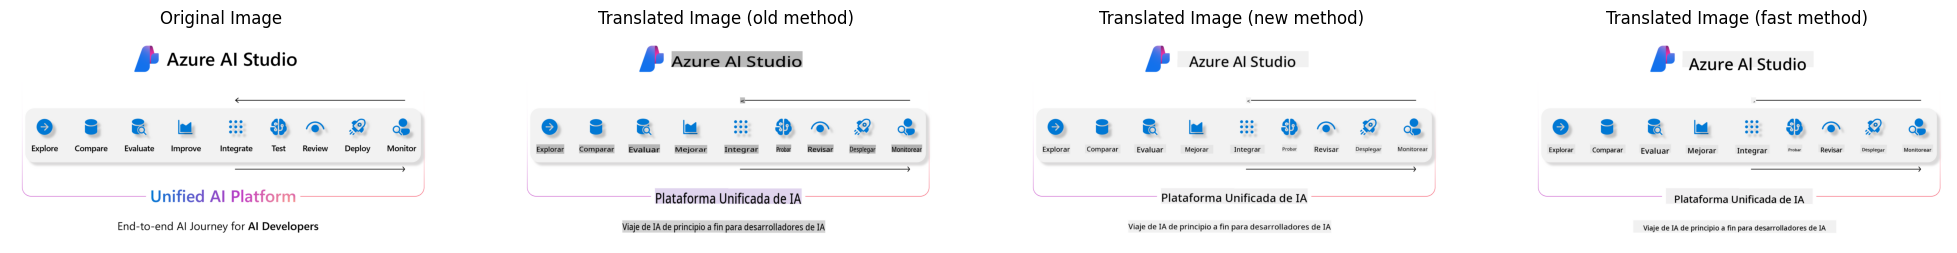

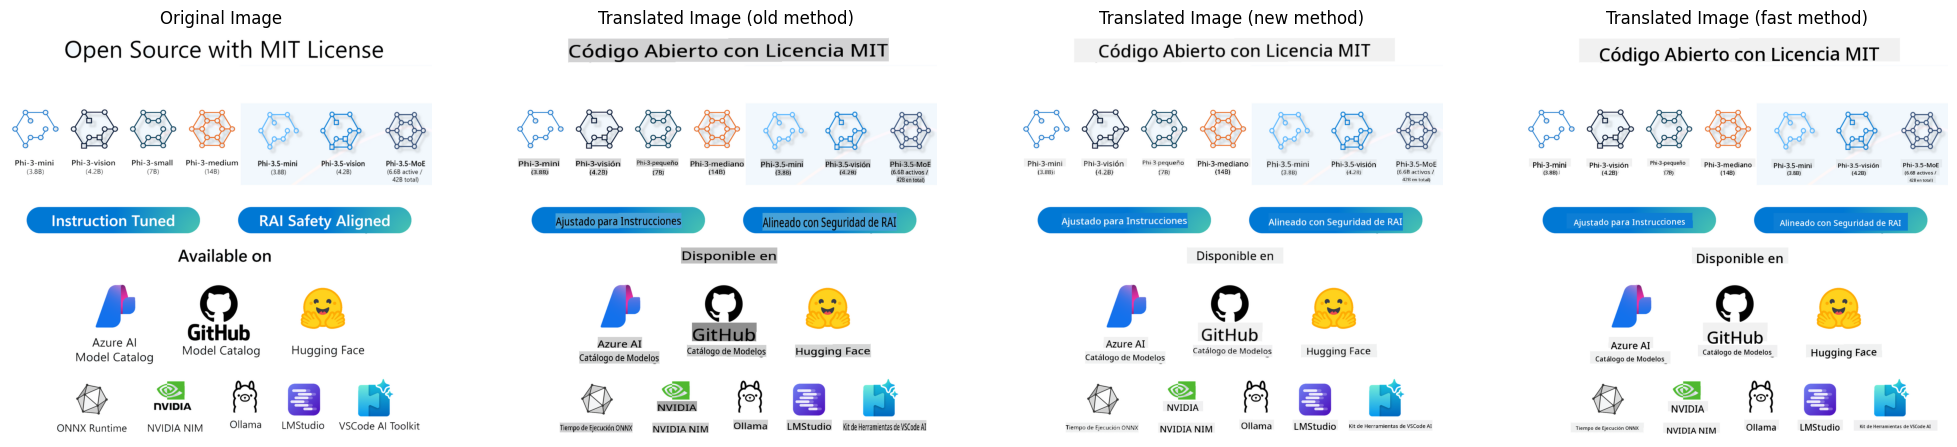

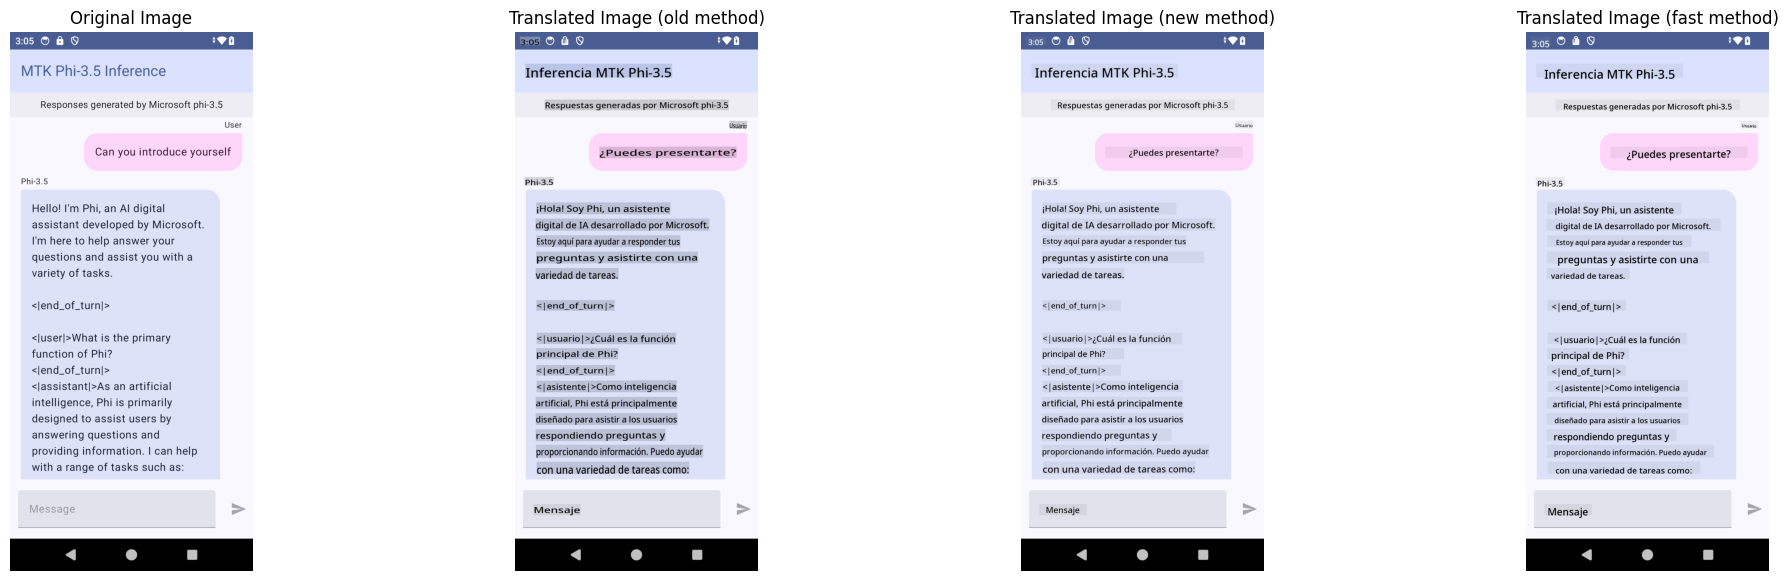

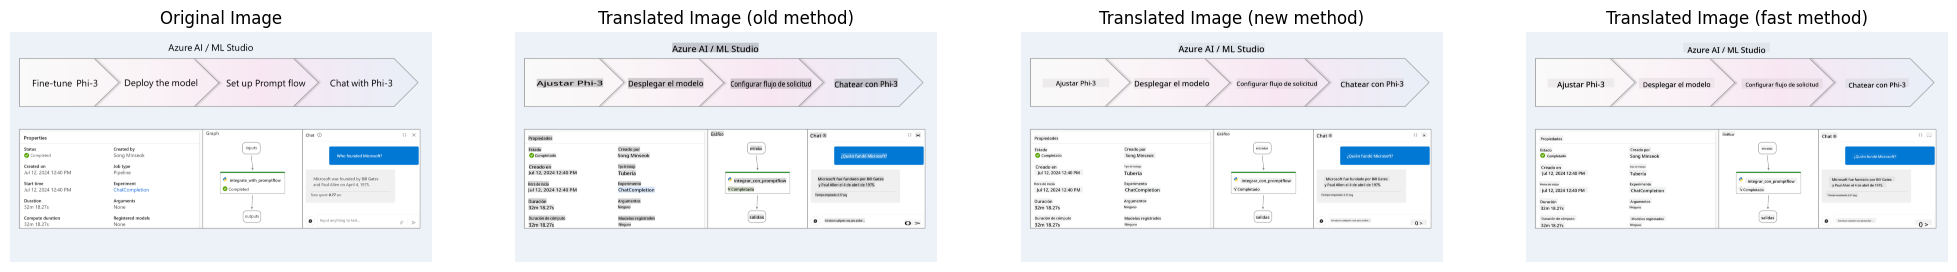

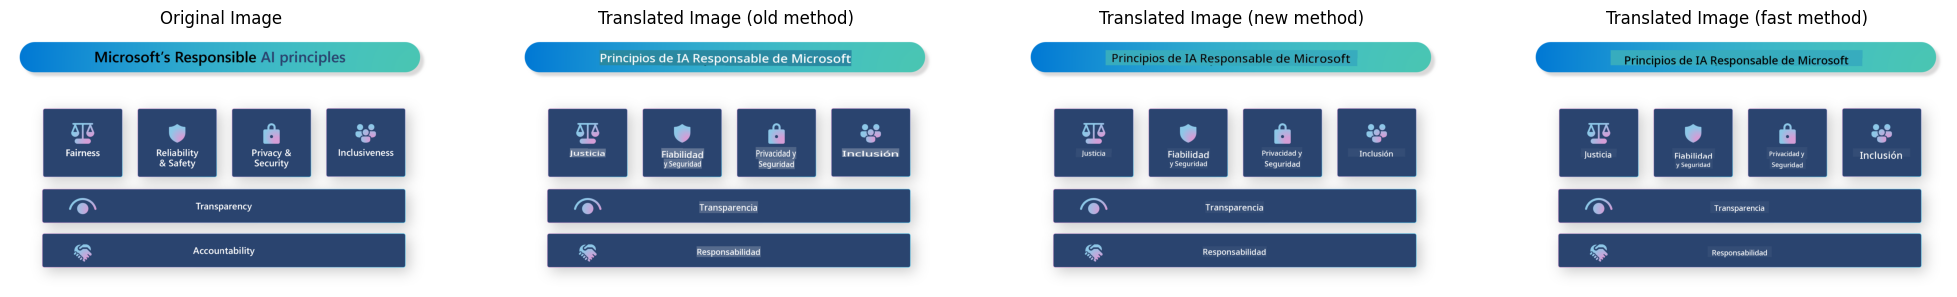

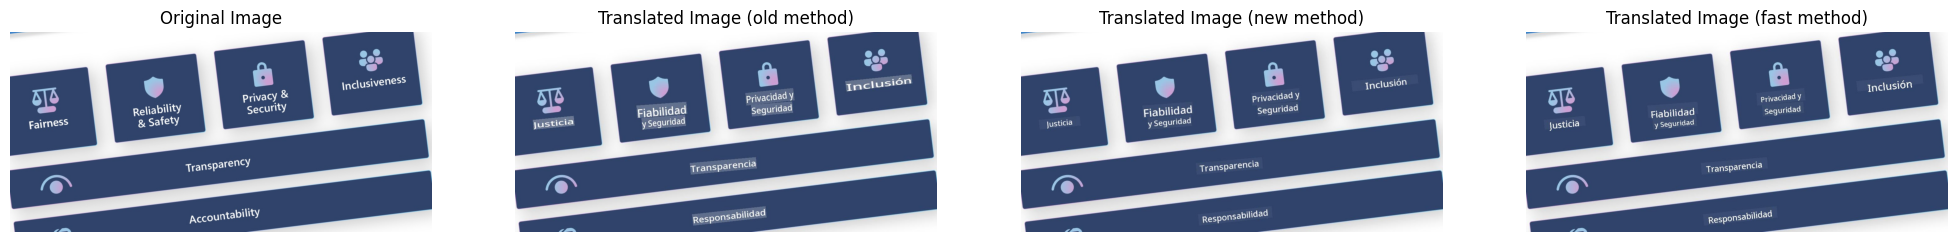

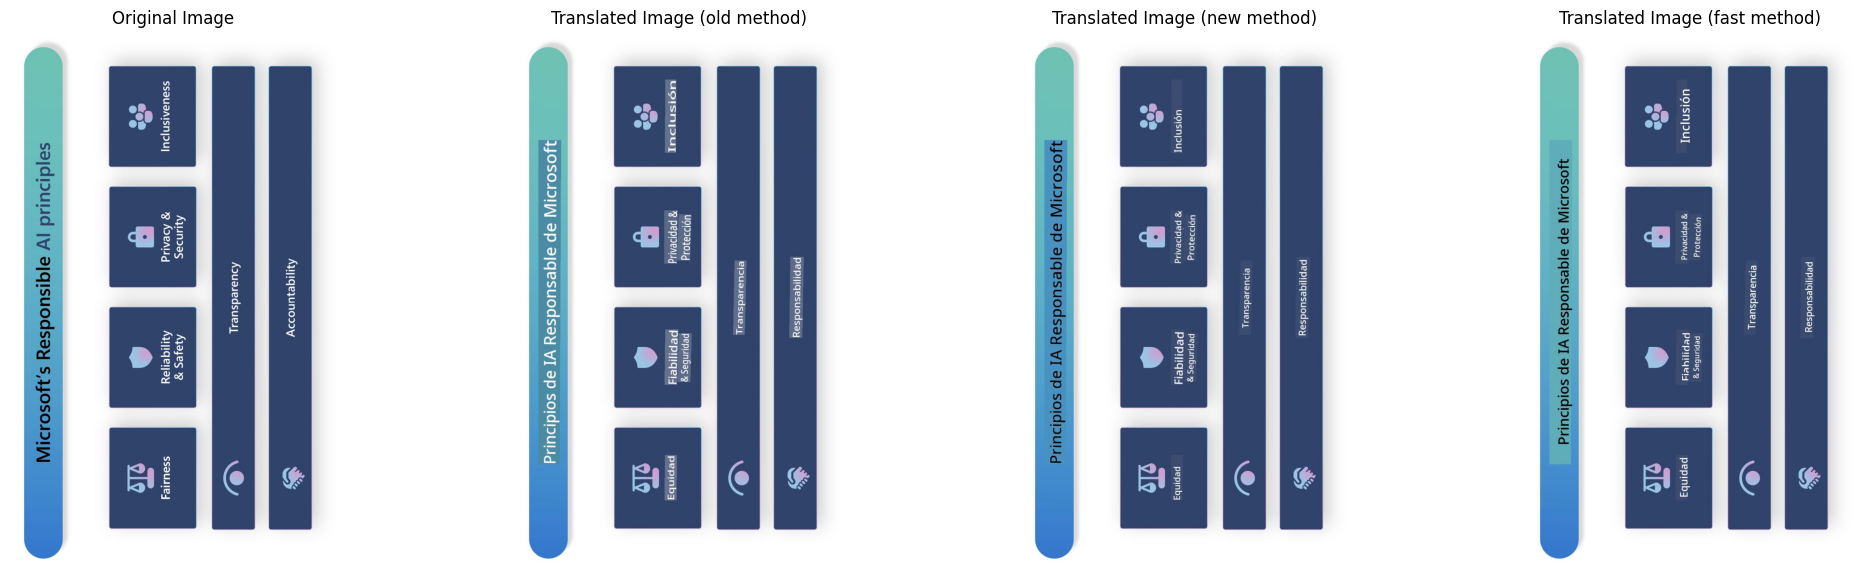

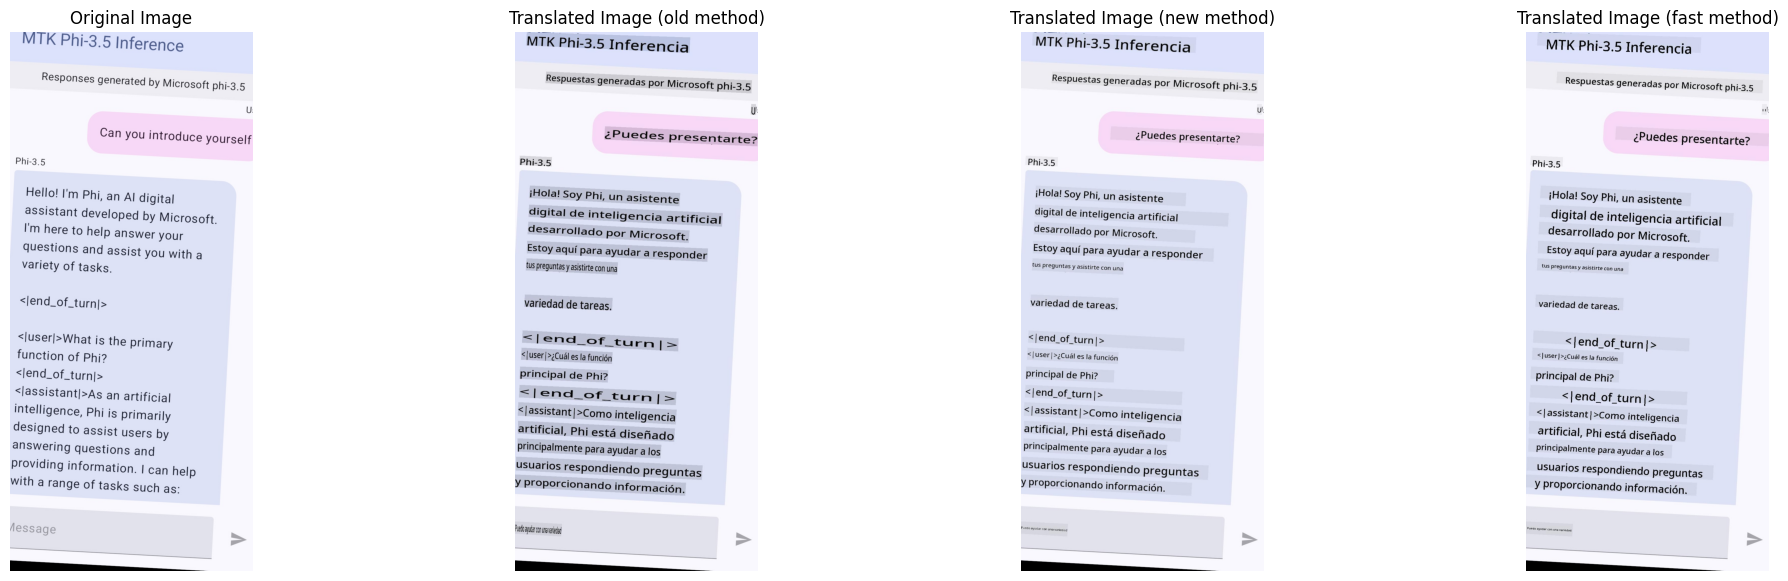

In [95]:

with open("translated_data.json", "r") as f:
    data = json.load(f)

# where annotated images are stored
destination_path = "./translated_images"
# where images that are annotated using the old method are stored
comparison_path = "./translated_images_old"
# where images that are annotated using the fast method are stored
fast_path = "./translated_images_fast"


for image_path, [line_bounding_boxes, translated_text_list] in data.items():

    original_image = Image.open(image_path)
    print()
    old_method_image = plot_annotated_image_old(
        image_path,
        line_bounding_boxes,
        translated_text_list,
        target_language_code,
        comparison_path,
        verbose=True,
    )
    new_method_image = plot_annotated_image(
        image_path,
        line_bounding_boxes,
        translated_text_list,
        target_language_code,
        destination_path,
        verbose=True,
    )

    fast_method_image = plot_annotated_image_fast(
        image_path,
        line_bounding_boxes,
        translated_text_list,
        target_language_code,
        fast_path,
        verbose=True,
    )

    translated_image = Image.open(new_method_image)
    comparison_image = Image.open(old_method_image)
    fast_method_image = Image.open(fast_method_image)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 4, figsize=(25, 7))
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original Image")
    axes[0].axis("off")

    axes[1].imshow(comparison_image)
    axes[1].set_title(f"Translated Image (old method)")
    axes[1].axis("off")

    axes[2].imshow(translated_image)
    axes[2].set_title(f"Translated Image (new method)")
    axes[2].axis("off")

    axes[3].imshow(fast_method_image)
    axes[3].set_title(f"Translated Image (fast method)")
    axes[3].axis("off")
plt.show()

# Archive

In [ ]:

with open("translated_data.json", "r") as f:
    data = json.load(f)

# where annotated images are stored
destination_path = "./translated_images"
# where images that are annotated using the old method are stored
comparison_path = "./translated_images_old"



for image_path, [line_bounding_boxes, translated_text_list] in data.items():

    original_image = Image.open(image_path)
    translated_image_path = plot_annotated_image(
        image_path,
        line_bounding_boxes,
        translated_text_list,
        target_language_code,
        destination_path,
        verbose=True,
    )
    
    comparison_image_path = plot_annotated_image_old(
        image_path,
        line_bounding_boxes,
        translated_text_list,
        target_language_code,
        comparison_path,
        verbose=True,
    )

    translated_image = Image.open(translated_image_path)
    comparison_image = Image.open(comparison_image_path)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # axes[0].imshow(original_image)
    # axes[0].set_title(f"Original Image")
    # axes[0].axis("off")

    axes[0].imshow(translated_image)
    axes[0].set_title(f"Translated Image (new method)")
    axes[0].axis("off")
    
    axes[1].imshow(comparison_image)
    axes[1].set_title(f"Translated Image (old method)")
    axes[1].axis("off")
    

plt.show()

Processing lines:   3%|▎         | 1/39 [00:00<00:07,  4.81it/s]

DomColor: [237, 242, 249]
DomColor: [250, 248, 249]


Processing lines:   8%|▊         | 3/39 [00:00<00:08,  4.45it/s]

DomColor: [250, 244, 247]
DomColor: [248, 234, 243]


Processing lines:  13%|█▎        | 5/39 [00:01<00:06,  5.16it/s]

DomColor: [0, 0, 0]
DomColor: [255, 255, 255]


Processing lines:  18%|█▊        | 7/39 [00:01<00:05,  5.59it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  23%|██▎       | 9/39 [00:01<00:05,  5.83it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  28%|██▊       | 11/39 [00:02<00:04,  5.92it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  33%|███▎      | 13/39 [00:02<00:04,  5.93it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  38%|███▊      | 15/39 [00:02<00:04,  5.94it/s]

DomColor: [0, 120, 212]
DomColor: [255, 255, 255]


Processing lines:  44%|████▎     | 17/39 [00:03<00:03,  6.00it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  49%|████▊     | 19/39 [00:03<00:03,  5.90it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  54%|█████▍    | 21/39 [00:03<00:03,  4.90it/s]

DomColor: [240, 240, 240]
DomColor: [255, 255, 255]


Processing lines:  59%|█████▉    | 23/39 [00:04<00:03,  5.08it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  64%|██████▍   | 25/39 [00:04<00:02,  5.46it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  69%|██████▉   | 27/39 [00:04<00:02,  5.50it/s]

DomColor: [240, 240, 240]
DomColor: [240, 240, 240]


Processing lines:  74%|███████▍  | 29/39 [00:05<00:01,  5.79it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  79%|███████▉  | 31/39 [00:05<00:01,  5.80it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  85%|████████▍ | 33/39 [00:05<00:01,  5.89it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  90%|████████▉ | 35/39 [00:06<00:00,  5.90it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines:  95%|█████████▍| 37/39 [00:06<00:00,  5.94it/s]

DomColor: [255, 255, 255]
DomColor: [255, 255, 255]


Processing lines: 100%|██████████| 39/39 [00:07<00:00,  5.52it/s]

DomColor: [255, 255, 255]


Total time taken to plot the annotated image (new method): 8.3655 seconds for images/00-01-architecture.png


Processing lines: 100%|██████████| 39/39 [00:04<00:00,  9.74it/s]


Total time taken to plot the annotated image: 5.3084 seconds for images/00-01-architecture.png


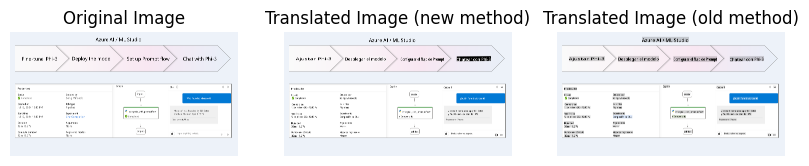

Azure AI / ML Studio
Fine-tune Phi-3
Deploy the model
Set up Prompt flow
Chat with Phi-3
Properties
Graph
Chat ®
×
Status
Created by
inputs
Completed
Song Minseok
Who founded Microsoft?
Created on
Job type
Jul 12, 2024 12:40 PM
Pipeline
integrate_with_promptflow
Microsoft was founded by Bill Gates
Start time
Experiment
Jul 12, 2024 12:40 PM
ChatCompletion
V Completed
and Paul Allen on April 4, 1975.
Time spent: 0.77 sec
Duration
Arguments
32m 18.27s
None
Compute duration
Registered models
outputs
32m 18.27s
None
Input anything to test ...
0 >
Azure AI / ML Studio
Ajustar Phi-3
Desplegar el modelo
Configurar el flujo de Prompt
Chatear con Phi-3
Propiedades
Gráfico
Chatear ®
×
Estado
Creado por
entradas
Completado
Song Minseok
¿Quién fundó Microsoft?
Creado en
Tipo de trabajo
12 de julio de 2024 12:40 PM
Pipeline
integrar_con_promptflow
Microsoft fue fundada por Bill Gates
Hora de inicio
Experimento
12 de julio de 2024 12:40 PM
Compleción de Chat
V Completado
y Paul Allen el 4 de abril d

In [52]:
image_path = 'images/00-01-architecture.png'
[line_bounding_boxes, translated_text_list] = data['images/00-01-architecture.png']


original_image = Image.open(image_path)
translated_image_path = plot_annotated_image(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    destination_path,
    verbose=True,
)

comparison_image_path = plot_annotated_image_old(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    comparison_path,
    verbose=True,
)

translated_image = Image.open(translated_image_path)
comparison_image = Image.open(comparison_image_path)

# Plot the images side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 8))
axes[0].imshow(original_image)
axes[0].set_title(f"Original Image")
axes[0].axis("off")

axes[1].imshow(translated_image)
axes[1].set_title(f"Translated Image (new method)")
axes[1].axis("off")

axes[2].imshow(comparison_image)
axes[2].set_title(f"Translated Image (old method)")
axes[2].axis("off")


plt.show()

for line in line_bounding_boxes:
    print(line["text"])

for line in translated_text_list:
    print(line)



Processing lines: 100%|██████████| 23/23 [00:00<00:00, 49.38it/s]


Total time taken to plot the annotated image: 0.6297 seconds


Processing lines: 100%|██████████| 23/23 [00:00<00:00, 76.01it/s]


Total time taken to plot the annotated image: 0.4651 seconds


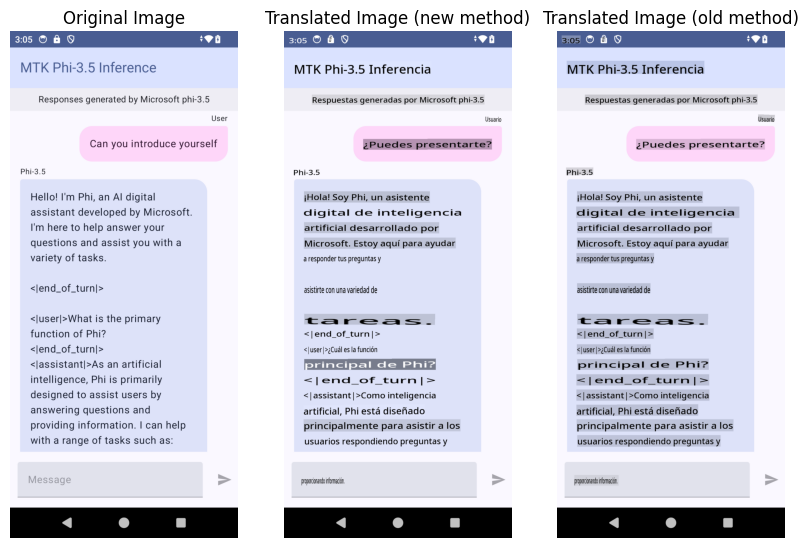

3:05
i .
MTK Phi-3.5 Inference
Responses generated by Microsoft phi-3.5
User
Can you introduce yourself
Phi-3.5
Hello! I'm Phi, an Al digital
assistant developed by Microsoft.
I'm here to help answer your
questions and assist you with a
variety of tasks.
<|end_of_turn|>
<|user|>What is the primary
function of Phi?
<|end_of_turn|>
<|assistant|>As an artificial
intelligence, Phi is primarily
designed to assist users by
answering questions and
providing information. I can help
with a range of tasks such as:
Message
3:05
Yo
MTK Phi-3.5 Inferencia
Respuestas generadas por Microsoft phi-3.5
Usuario
¿Puedes presentarte?
Phi-3.5
¡Hola! Soy Phi, un asistente
digital de inteligencia 
artificial desarrollado por
Microsoft. Estoy aquí para ayudar
a responder tus preguntas y
asistirte con una variedad de
tareas.
<|end_of_turn|>
<|user|>¿Cuál es la función
principal de Phi?
<|end_of_turn|>
<|assistant|>Como inteligencia
artificial, Phi está diseñado
principalmente para asistir a los
usuarios respond

In [41]:
image_path = 'images/demo.png'
[line_bounding_boxes, translated_text_list] = data['images/demo.png']




original_image = Image.open(image_path)
translated_image_path = plot_annotated_image(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    destination_path,
    verbose=True,
)

comparison_image_path = plot_annotated_image_old(
    image_path,
    line_bounding_boxes,
    translated_text_list,
    target_language_code,
    comparison_path,
    verbose=True,
)

translated_image = Image.open(translated_image_path)
comparison_image = Image.open(comparison_image_path)

# Plot the images side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 8))
axes[0].imshow(original_image)
axes[0].set_title(f"Original Image")
axes[0].axis("off")

axes[1].imshow(translated_image)
axes[1].set_title(f"Translated Image (new method)")
axes[1].axis("off")

axes[2].imshow(comparison_image)
axes[2].set_title(f"Translated Image (old method)")
axes[2].axis("off")


plt.show()

for line in line_bounding_boxes:
    print(line["text"])

for line in translated_text_list:
    print(line)



### Most recent plot_annotated